# Covid Dataset

SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. 

## Train the model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/classification_of_diseases/covid_dataset.zip', 'r') 
zip_ref.extractall('/new') 
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib

data_dir_covid = pathlib.Path('/new/COVID')
data_dir_non_covid = pathlib.Path('/new/non-COVID')

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/new', output="/here", seed=1337, ratio=(0.7, 0.2, 0.1)) 

Copying files: 2481 files [00:00, 3970.49 files/s]


In [ ]:
data_dir_train = pathlib.Path('/here/train')
data_dir_val = pathlib.Path('/here/val')
data_dir_test = pathlib.Path('/here/test')

In [ ]:
#check total image count

#as it's already known that all images are of type.png.
img_count_train = len(list(data_dir_train.glob('*/*.png'))) 
img_count_val = len(list(data_dir_val.glob('*/*.png'))) 
img_count_test = len(list(data_dir_test.glob('*/*.png'))) 

print("Image count in Train set:", img_count_train)
print("Image count in Val set:", img_count_val)
print("Image count in Test set:", img_count_test)

Image count in Train set: 1736
Image count in Val set: 495
Image count in Test set: 250


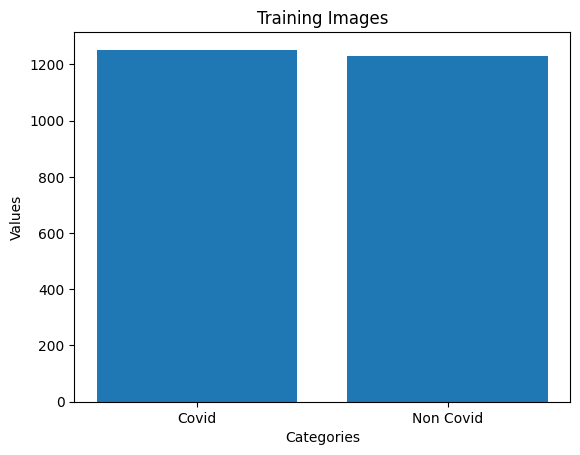

In [ ]:
class_names = {0: 'Covid', 1: 'Non Covid'}

values = [1252, 1229]
categories = ['Covid', 'Non Covid']

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Training Images')

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    batch_size=32,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    target_size=(256,256),
                                                    shuffle=True) 

validation_generator = train_datagen.flow_from_directory(data_dir_val,
                                                          batch_size=32,
                                                          color_mode='grayscale',
                                                          class_mode='categorical',
                                                          target_size=(256,256),
                                                          shuffle=True) 

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(data_dir_test,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    color_mode='grayscale',
                                                    target_size=(256,256),
                                                    shuffle=False) 

Found 1736 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


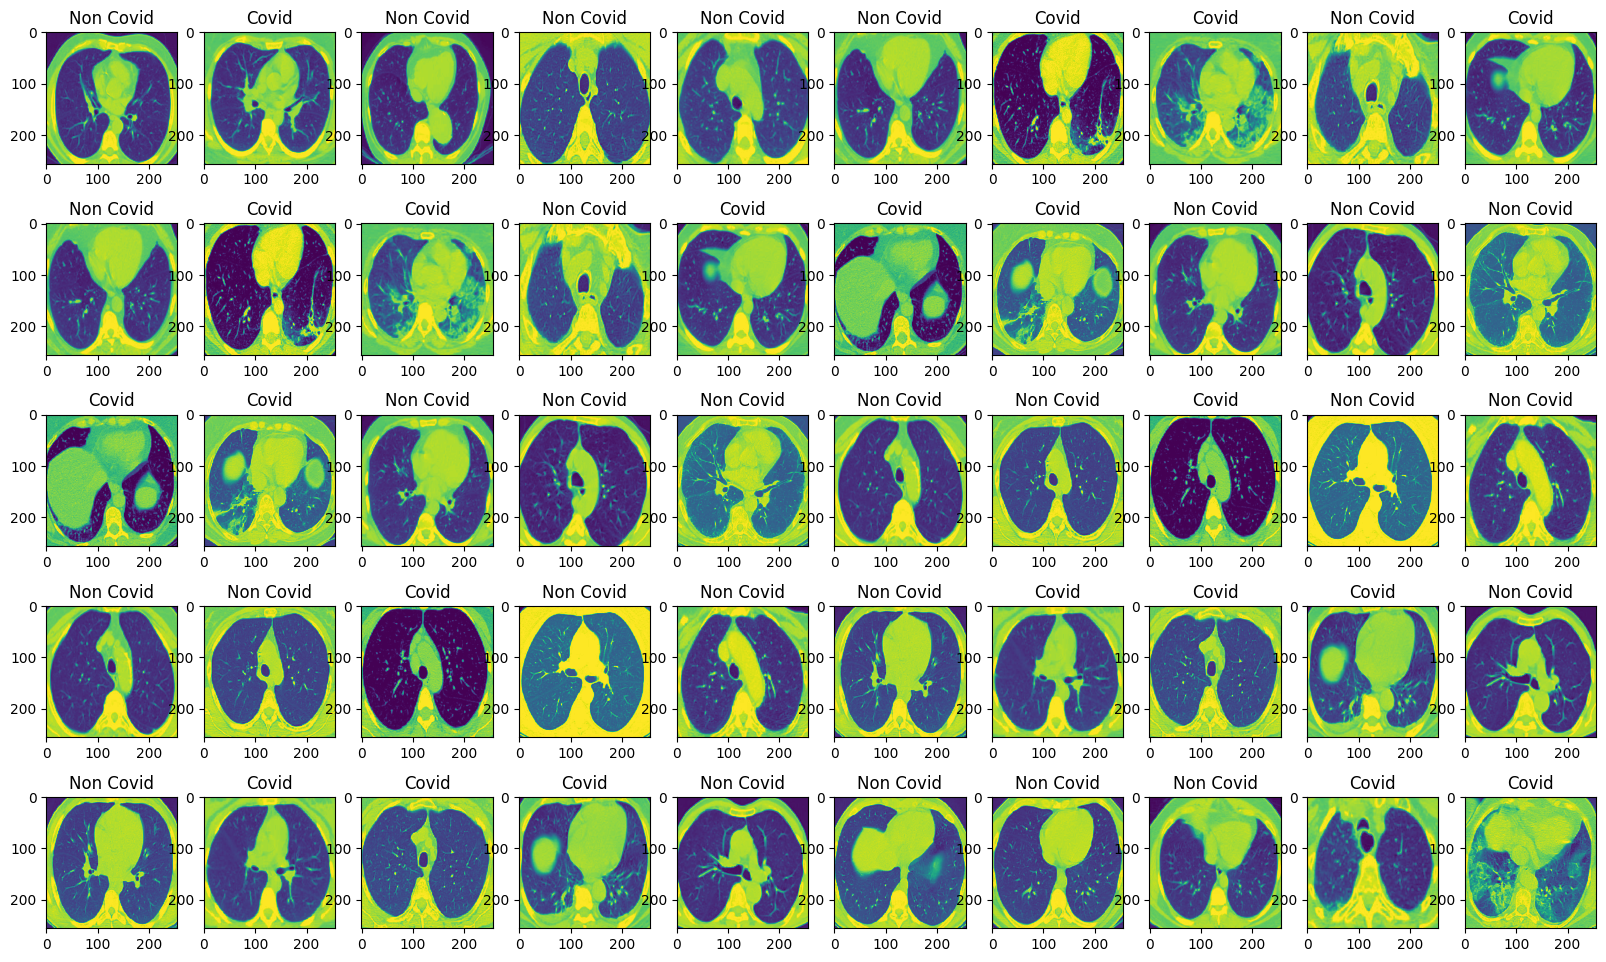

In [ ]:
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(5, 10, figsize=(20, 12))

    for i in range(5):
        for j in range(10):
            img = images_arr[i * 5 + j]
            label = labels_arr[i * 5 + j]
            axes[i][j].imshow(img)
            #axes[i][j].axis('off')
            l = np.argmax(label)
            axes[i][j].set_title(class_names[l], fontsize=12)
    plt.show()

sample_training_images, sample_training_labels = next(train_generator)
plotImages(sample_training_images[:50], sample_training_labels[:50])

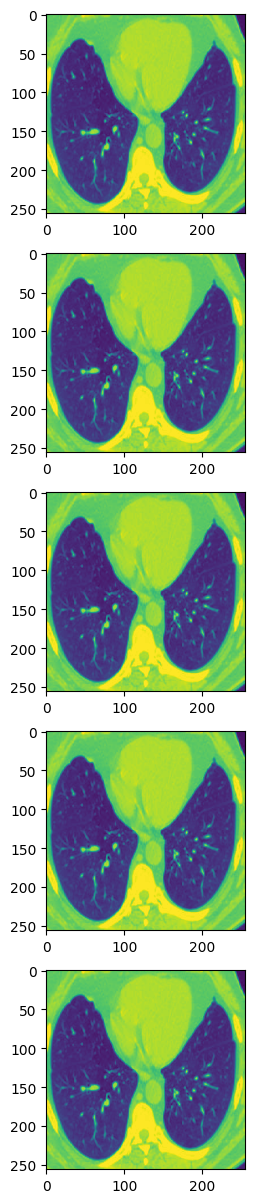

In [ ]:
def plotAugmentedImages(images_arr):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))

    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.show()

n = 5 # Choose an image
augmented_images = [train_generator[0][0][n] for i in range(5)]
plotAugmentedImages(augmented_images)

In [ ]:
import seaborn as sns

def plot_diagrams(history, h=16, w=6):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(h, w))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(500, activation='relu')])

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
import datetime

callbacks = []

checkpoint_filepath = '/content/drive/MyDrive/classification_of_diseases/covid_model.hdf5'
save_best_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback) 

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=20,
                    epochs=100,
                    validation_steps=15,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3484 - accuracy: 0.6047
Epoch 1: val_loss improved from inf to 0.68565, saving model to /content/drive/MyDrive/classification_of_diseases/covid_model.hdf5
20/20 [==============================] - 34s 779ms/step - loss: 1.3484 - accuracy: 0.6047 - val_loss: 0.6857 - val_accuracy: 0.5042
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7581
Epoch 2: val_loss did not improve from 0.68565
20/20 [==============================] - 6s 241ms/step - loss: 0.5236 - accuracy: 0.7581 - val_loss: 0.7095 - val_accuracy: 0.5042
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.7469
Epoch 3: val_loss improved from 0.68565 to 0.64852, saving model to /content/drive/MyDrive/classification_of_diseases/covid_model.hdf5
20/20 [==============================] - 7s 375ms/step - loss: 0.5322 - accuracy: 0.7469 - val_loss: 0.6485 - val_accuracy: 0.6479
Epoch 4/

In [ ]:
train_loss, train_acc = model.evaluate(train_generator, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

55/55 - 7s - loss: 0.0766 - accuracy: 0.9810 - 7s/epoch - 132ms/step
Train accuracy: 98.10%


## Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

8/8 - 1s - loss: 0.1413 - accuracy: 0.9560 - 1s/epoch - 165ms/step
Test accuracy: 95.60%


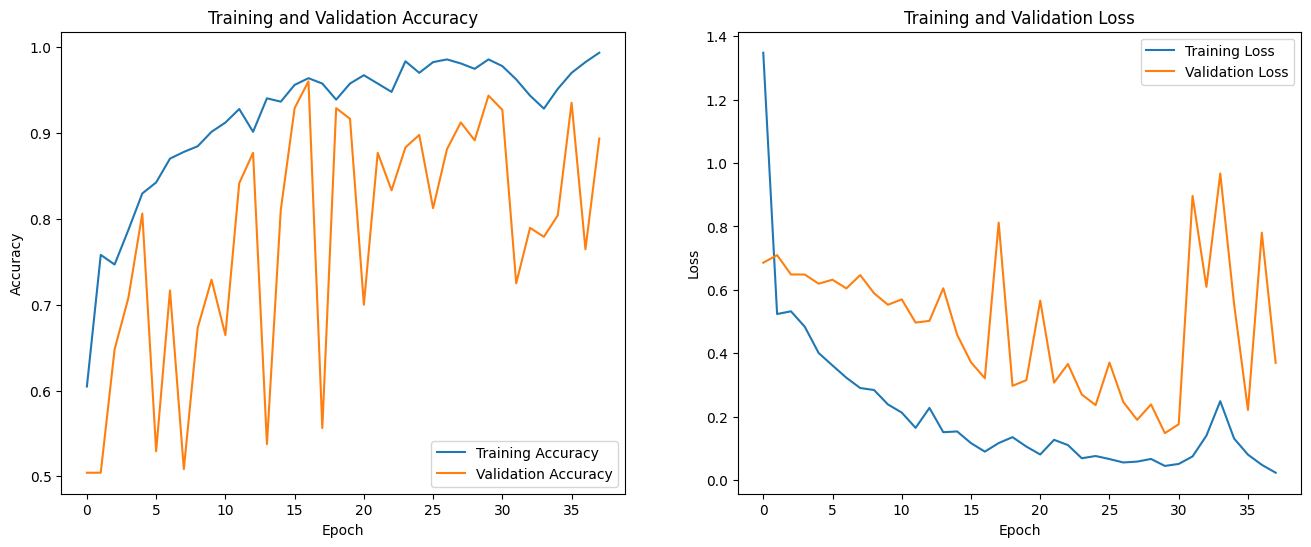

In [ ]:
plot_diagrams(history)

8/8 [==============================] - 1s 118ms/step


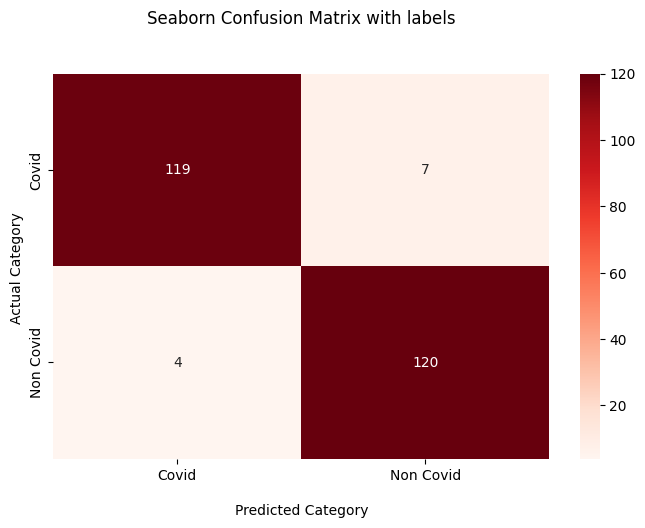

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, h=8, w=5):
    fig, ax = plt.subplots(figsize=(h, w))
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='d')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Covid', 'Non Covid'])
    ax.yaxis.set_ticklabels(['Covid', 'Non Covid'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

predicted_labels = model.predict(test_generator)
predicted_classes = np.argmax(predicted_labels, axis=1)
y_test = np.array(test_generator.labels)
plot_confusion_matrix(y_test, predicted_classes)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       126
           1       0.94      0.97      0.96       124

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



## Load the model

In [ ]:
from keras.models import load_model
best_model = load_model(checkpoint_filepath)

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
from keras.utils.layer_utils import count_params

trainable_params = count_params(best_model.trainable_weights)
non_trainable_params = count_params(best_model.non_trainable_weights)
print("Trainable params:", trainable_params)
print("Non trainable params:", non_trainable_params)

Trainable params: 8586334
Non trainable params: 512


In [ ]:
train_loss, train_acc = best_model.evaluate(train_generator, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

55/55 - 7s - loss: 0.0766 - accuracy: 0.9810 - 7s/epoch - 128ms/step
Train accuracy: 98.10%


In [ ]:
test_loss, test_acc = best_model.evaluate(test_generator, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

8/8 - 1s - loss: 0.1413 - accuracy: 0.9560 - 954ms/epoch - 119ms/step
Test accuracy: 95.60%
